In [3]:
%reload_ext autoreload
%autoreload 2
import pandas
import numpy
import matplotlib

from lib.sampling import *


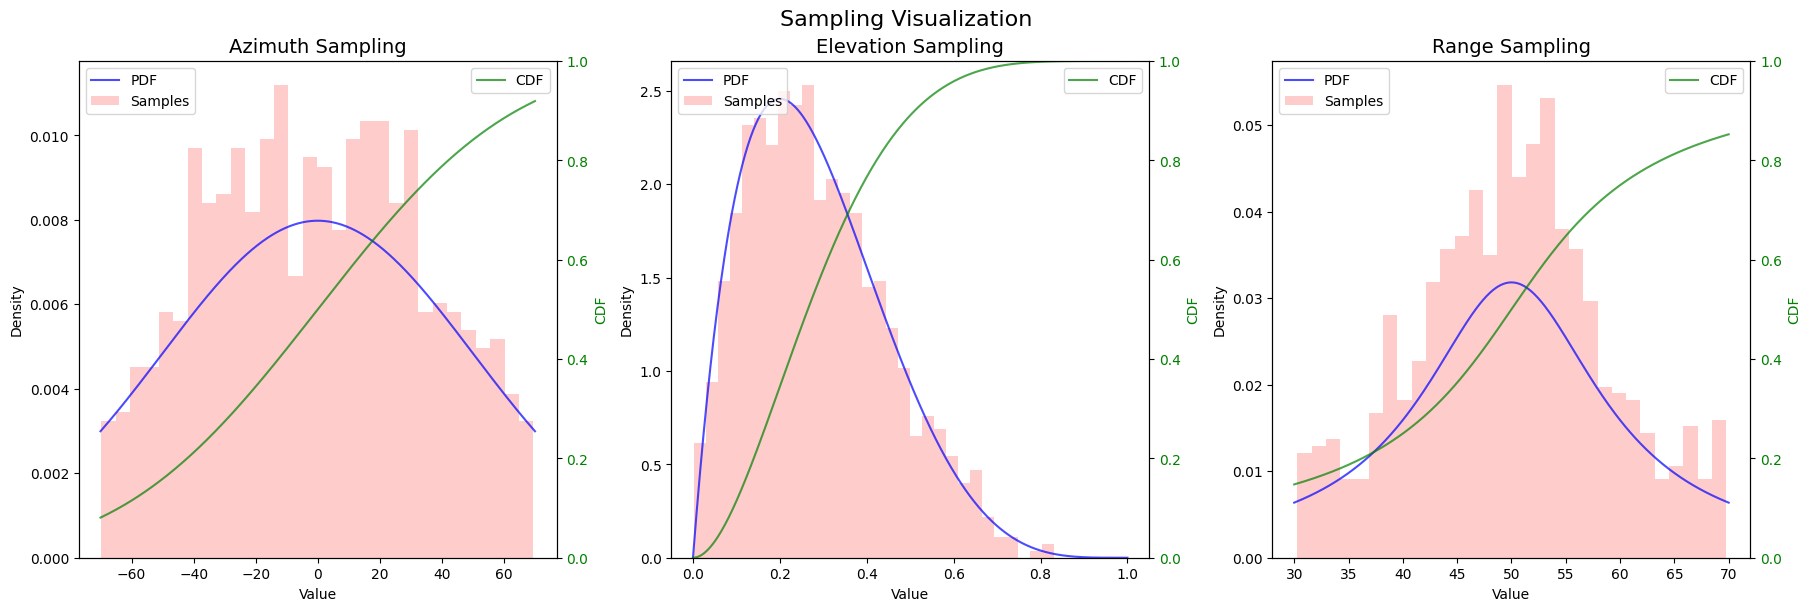

In [16]:
# Example Usage
sampling_configs = {
    "azimuth": {"distribution": "gaussian", "params": {"mean": 0, "std_dev": 50}, "bounds": (-70, 70)},
    "elevation": {"distribution": "beta", "params": {"alpha": 2, "beta": 5}, "bounds": (0, 1)},
    "range": {"distribution": "cauchy", "params": {"loc": 50, "scale": 10}, "bounds": (30, 70)},
}

# Initialize the sampler
sampler = MultiDimensionalSampler(sampling_configs)

# Generate and visualize samples
sampler.visualize_sampling(num_samples=1000)